In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
import os
import time
import warnings
import datetime
import logging
import itertools
warnings.filterwarnings("ignore")

## **Step 1: Data Loading and Structuring:** 

In [2]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

logger.info('data collection and augmentation will start')


DFs_List = ['Industry_Unlevered_Beta_DF', 'Tax_Rate_DF', 'Specific_Revenues_DF', 'Companies_DF', 'Market_Risk_Premium_DF', 'Gearing_CostOfDebt_DF', 'Risk_Free_Rate_DF', 'Illiquidity_Premium_DF']
file_paths = [
    'Excel_Data/Industry Unlevered Beta Final.xlsx',
    'Excel_Data/Tax Rate.xlsx',
    'Excel_Data/Specific Revenues.xlsx',
    'Excel_Data/Companies.xlsx',
    'Excel_Data/Market Risk Premium.xlsx',
    'Excel_Data/Gearing.xlsx',
    'Excel_Data/Risk Free Rate.xlsx',
    'Excel_Data/Illiquidity Premium.xlsx'
]

def load_dataframes(DFs_List, file_paths):
    dataframes = {}

    try:
        for i in range(len(DFs_List)):
            dataframes[DFs_List[i]] = pd.read_excel(file_paths[i])
            logger.info('Dataframe {} loaded successfully'.format(DFs_List[i]))

        logger.info('Dataframes loaded successfully')

        return dataframes
    
    except Exception as e:
        logger.error('Error loading dataframes: {}'.format(e))

dataframes = load_dataframes(DFs_List, file_paths)


# Industry Unlevered Beta DataFrame:

Industry_Unlevered_Beta_DF = dataframes['Industry_Unlevered_Beta_DF']

IndustryUnleveredBeta_DF = Industry_Unlevered_Beta_DF[['Industry Name', 'Year', 'Unlevered Beta']]
unique_sectors = IndustryUnleveredBeta_DF['Industry Name'].unique()

# Select sectors with data for all years from 2014 to 2023

years = list(range(2014, 2024))

def check_missing_years(df, unique_sectors, years):
    sectors_with_all_years = []
    for sector in unique_sectors:
        sector_data = df[df['Industry Name'] == sector]
        sector_years = sorted(sector_data['Year'].unique())
        missing_years = [year for year in years if year not in sector_years]
        if not missing_years:
            sectors_with_all_years.append(sector)

    logger.info('Number of Sectors with data for all years: {}'.format(len(sectors_with_all_years)))
    return sectors_with_all_years

sectors_with_all_years = check_missing_years(IndustryUnleveredBeta_DF, unique_sectors, years)
IndustryUnleveredBeta_DF_Filtered = IndustryUnleveredBeta_DF[IndustryUnleveredBeta_DF['Industry Name'].isin(sectors_with_all_years)]

IndustryUnleveredBeta_DF_Filtered = IndustryUnleveredBeta_DF_Filtered.copy()
IndustryUnleveredBeta_DF_Filtered['Year'] = pd.to_datetime(IndustryUnleveredBeta_DF_Filtered['Year'].astype(str) + '-12-31',format='%Y-%m-%d')





logger.info('Dataframe IndustryUnleveredBeta_DF_Filtered is ready')

#Revenues DataFrames:
Total_Revenues_DF = dataframes['Specific_Revenues_DF']

# Remove ' MAD' from Total Revenue and Specific Revenue columns + Convert into float
Total_Revenues_DF['Total Revenue'] = Total_Revenues_DF['Total Revenue'].str.replace(' MAD', '').str.replace(',', '').astype(float)
Total_Revenues_DF['Specific Revenue'] = Total_Revenues_DF['Specific Revenue'].str.replace(' MAD', '').str.replace(',', '').astype(float)
logger.info('Total Revenue and Specific Revenue columns are cleaned and converted to float')



# Proportion from Total Revenue (Specific Revenue/Total Revenue)
Total_Revenues_DF['Proportion from Total Revenue (Specific Revenue/Total Revenue)'] = Total_Revenues_DF['Specific Revenue'] / Total_Revenues_DF['Total Revenue']
logger.info('Proportion from Total Revenue (Specific Revenue/Total Revenue) column is successfully calculated')


# Specific Revenues dataframe
SpecificRevenues_DF = Total_Revenues_DF[['Date (Year)', 'Company Name', 'Sector', 'Specific Revenue', 'Proportion from Total Revenue (Specific Revenue/Total Revenue)']]
SpecificRevenues_DF.columns = ['Year', 'Company Name', 'Industry Name', 'Specific Revenue', 'Proportion from Total Revenue']

SpecificRevenues_DF = SpecificRevenues_DF.copy()
SpecificRevenues_DF['Year'] = pd.to_datetime(SpecificRevenues_DF['Year'].astype(str) + '-12-31',format='%Y-%m-%d')

logger.info('Specific Revenues dataframe is ready')


# Total Revenues dataframe
TotalRevenues_DF= Total_Revenues_DF[['Date (Year)', 'Company Name', 'Total Revenue']].drop_duplicates()
TotalRevenues_DF.columns = ['Year', 'Company Name', 'Total Revenue']

TotalRevenues_DF = TotalRevenues_DF.copy()
TotalRevenues_DF['Year'] = pd.to_datetime(TotalRevenues_DF['Year'].astype(str) + '-12-31',format='%Y-%m-%d')


logger.info('Total Revenues dataframe is ready')


# Company Unlevered Beta DataFrame:

merged_df = pd.merge(SpecificRevenues_DF, TotalRevenues_DF, on=['Year', 'Company Name'])
merged_df = pd.merge(merged_df, IndustryUnleveredBeta_DF_Filtered, on=['Year', 'Industry Name'])
merged_df['Product'] = merged_df['Proportion from Total Revenue'] * merged_df['Unlevered Beta']
CompanyUnleveredBeta_DF = merged_df.groupby(['Company Name', 'Year']).sum().reset_index()
CompanyUnleveredBeta_DF.rename(columns={'Product': 'Company Unlevered Beta'}, inplace=True)
CompanyUnleveredBeta_DF = CompanyUnleveredBeta_DF[['Year', 'Company Name', 'Company Unlevered Beta']]

print(CompanyUnleveredBeta_DF)

logger.info('Company Unlevered Beta dataframe is ready')


# Companies DataFrame:

Companies_DF = dataframes['Companies_DF']
logger.info('Companies dataframe is ready')

# Tax Rate DataFrame:

Tax_Rate_DF = dataframes['Tax_Rate_DF']
logger.info('Tax Rate dataframe is ready')

# Update Companies DataFrame with Tax Rate
Companies_DF = pd.merge(Companies_DF, Tax_Rate_DF, on='Category (Depends on the Taxable Income, in MAD)')
logger.info('Companies dataframe is updated with Tax Rate')


# Gearing (D/E), (D/D+E) and Cost of Debt DataFrame:

Gearing_CostOfDebt_DF = dataframes['Gearing_CostOfDebt_DF']
Gearing_CostOfDebt_DF.rename(columns={'Company': 'Company Name'}, inplace=True)
Gearing_CostOfDebt_DF['Year'] = pd.to_datetime(Gearing_CostOfDebt_DF['Year'].astype(str) + '-12-31',format='%Y-%m-%d')



Gearing_DF = Gearing_CostOfDebt_DF[['Year', 'Company Name', 'Gearing (D/E)']]
Gearing_DF['Gearing (D/D+E)'] = Gearing_DF['Gearing (D/E)'] / (1 + Gearing_DF['Gearing (D/E)'])
Gearing_DF = Gearing_DF[['Year', 'Company Name', 'Gearing (D/E)', 'Gearing (D/D+E)']]
logger.info('Gearing (D/E), (D/D+E) dataframe is ready')



CostofDebt_DF = Gearing_CostOfDebt_DF[['Year', 'Company Name',  'Cost of Debt']]
logger.info('Cost of Debt dataframe is ready')


# Levered Beta DataFrame:
merged_df = pd.merge(Companies_DF, Gearing_DF, on=['Company Name'])
merged_df = pd.merge(merged_df, CompanyUnleveredBeta_DF, on=['Year', 'Company Name'])
merged_df['Levered Beta'] = merged_df['Company Unlevered Beta'] * (1 + (1 - merged_df['Tax Rate']) * merged_df['Gearing (D/E)'])
LeveredBeta_DF = merged_df[['Year', 'Company Name', 'Company Unlevered Beta', 'Levered Beta']].copy()

logger.info('Levered Beta dataframe is ready')



# Risk-Free Rate DataFrame:
RiskFreeRate_DF = dataframes['Risk_Free_Rate_DF']
RiskFreeRate_DF['RFR'] = RiskFreeRate_DF['RFR'] / 100
RiskFreeRate_DF['Year'] = pd.to_datetime(RiskFreeRate_DF['Year'].astype(str) + '-12-31',format='%Y-%m-%d')
RiskFreeRate_DF.rename(columns={'RFR': 'Risk Free Rate'}, inplace=True)
logger.info('Risk-Free Rate dataframe is ready')


# Market Risk Premium DataFrame:
MarketRiskPremium_DF = dataframes['Market_Risk_Premium_DF']
MarketRiskPremium_DF['Year'] = pd.to_datetime(MarketRiskPremium_DF['Year'].astype(str) + '-12-31',format='%Y-%m-%d')
logger.info('Market Risk Premium dataframe is ready')
print(MarketRiskPremium_DF)

# Illiquidity Premium DataFrame (Assuming that Illiquidity Risk Premium = 1)
LiquidityRiskPremium_DF = dataframes['Illiquidity_Premium_DF']
LiquidityRiskPremium_DF['Year'] = pd.to_datetime(LiquidityRiskPremium_DF['Year'].astype(str) + '-12-31',format='%Y-%m-%d')
logger.info('Illiquidity Premium dataframe is ready')


# Cost of Equity DataFrame:
merged_df = pd.merge(LeveredBeta_DF, RiskFreeRate_DF, on='Year')
merged_df = pd.merge(merged_df, MarketRiskPremium_DF, on='Year')
merged_df = pd.merge(merged_df, LiquidityRiskPremium_DF, on='Year')
merged_df['Cost of Equity'] = merged_df['Risk Free Rate'] + (merged_df['Levered Beta'] * merged_df['Market Risk Premium']) + merged_df['Illiquidity Premium']
CostOfEquity_DF = merged_df.copy()
logger.info('Cost of Equity dataframe is ready')
print(CostOfEquity_DF)

# Weighted Average Cost Of Capital (WACC) DataFrame:
merged_df = pd.merge(Gearing_DF, CostofDebt_DF, on=['Year', 'Company Name'])
merged_df = pd.merge(merged_df, CostOfEquity_DF, on=['Year', 'Company Name'])
merged_df = pd.merge(merged_df, Companies_DF[['Company Name', 'Tax Rate']], on='Company Name')

WACC_DF = merged_df.copy()

WACC_DF['WACC'] = (
    WACC_DF['Cost of Equity'] * (1 - WACC_DF['Gearing (D/D+E)']) +
    (WACC_DF['Cost of Debt'] * WACC_DF['Gearing (D/D+E)'] * (1 - WACC_DF['Tax Rate']))
)




logger.info('WACC dataframe is ready')

print( WACC_DF)



2024-12-13 09:36:18,197 - INFO - data collection and augmentation will start
2024-12-13 09:36:18,588 - INFO - Dataframe Industry_Unlevered_Beta_DF loaded successfully
2024-12-13 09:36:18,599 - INFO - Dataframe Tax_Rate_DF loaded successfully
2024-12-13 09:36:18,614 - INFO - Dataframe Specific_Revenues_DF loaded successfully
2024-12-13 09:36:18,625 - INFO - Dataframe Companies_DF loaded successfully
2024-12-13 09:36:18,634 - INFO - Dataframe Market_Risk_Premium_DF loaded successfully
2024-12-13 09:36:18,643 - INFO - Dataframe Gearing_CostOfDebt_DF loaded successfully
2024-12-13 09:36:18,651 - INFO - Dataframe Risk_Free_Rate_DF loaded successfully
2024-12-13 09:36:18,660 - INFO - Dataframe Illiquidity_Premium_DF loaded successfully
2024-12-13 09:36:18,661 - INFO - Dataframes loaded successfully
2024-12-13 09:36:18,692 - INFO - Number of Sectors with data for all years: 92
2024-12-13 09:36:18,697 - INFO - Dataframe IndustryUnleveredBeta_DF_Filtered is ready
2024-12-13 09:36:18,699 - INFO 

         Year         Company Name  Company Unlevered Beta
0  2014-12-31         AFRIQUIA GAZ                0.751219
1  2015-12-31         AFRIQUIA GAZ                0.952744
2  2016-12-31         AFRIQUIA GAZ                0.891521
3  2017-12-31         AFRIQUIA GAZ                1.043079
4  2018-12-31         AFRIQUIA GAZ                0.790308
5  2019-12-31         AFRIQUIA GAZ                0.848772
6  2020-12-31         AFRIQUIA GAZ                0.776165
7  2021-12-31         AFRIQUIA GAZ                0.722113
8  2022-12-31         AFRIQUIA GAZ                0.652079
9  2023-12-31         AFRIQUIA GAZ                0.615766
10 2014-12-31  Maroc Telecom (IAM)                0.741197
11 2015-12-31  Maroc Telecom (IAM)                0.721835
12 2016-12-31  Maroc Telecom (IAM)                0.700600
13 2017-12-31  Maroc Telecom (IAM)                0.836076
14 2018-12-31  Maroc Telecom (IAM)                0.754997
15 2019-12-31  Maroc Telecom (IAM)                0.6243

# Data Augmentation Using OU Process with Euler Maruyama Discretization:

In [3]:
import numpy as np
from datetime import timedelta

logger.info('Data augmentation will start here')
# Here I ensure that 'Year' column is in datetime format

if WACC_DF['Year'].dtype != 'datetime64[ns]':
    WACC_DF['Year'] = pd.to_datetime(WACC_DF['Year'])
    logger.info("'Year' column converted to datetime format.")

# The Variables to Augment:
variables_to_augment = [
    'Gearing (D/E)',
    'Company Unlevered Beta',
    'Risk Free Rate',
    'Market Risk Premium',
    'Illiquidity Premium',
    'Cost of Debt'
]

# The estimation of the OU process parameters
def estimate_OU_parameters(start_value, end_value, T):
    """
    Estimates the parameters for the OU process between two values over time T.

    Args:
        start_value (float): The starting value of the variable.
        end_value (float): The ending value of the variable.
        T (float): The total time duration between start and end in years.

    Returns:
        mu (float): The long-term mean.
        theta (float): The speed of mean reversion.
        sigma (float): The volatility parameter.
    """
    mu = (start_value + end_value) / 2  # Long-term mean
    theta = 0.5  # Mean reversion speed
    sigma = abs(end_value - start_value) / np.sqrt(T) if T > 0 else 0  # Volatility estimate
    return mu, theta, sigma

2024-12-13 09:36:18,829 - INFO - Data augmentation will start here


In [4]:
def OU_bridge_simulation(X0, XT, mu, theta, sigma, T, delta_t):
    """
    Simulates an Ornstein-Uhlenbeck bridge between X0 and XT over time T.

    Args:
        X0 (float): The initial value.
        XT (float): The terminal value.
        mu (float): The long-term mean.
        theta (float): The speed of mean reversion.
        sigma (float): The volatility parameter.
        T (float): Total time duration in days.
        delta_t (float): Time step size in days.

    Returns:
        t (np.ndarray): Array of time steps.
        X (np.ndarray): Simulated values at each time step.
    """
    np.random.seed(42) 
    N = int(T / delta_t) + 1  # Number of steps
    t = np.linspace(0, T, N) # Time grid
    X = np.zeros(N) # Initialize the process
    X[0] = X0 # Initial value

    for i in range(1, N): # Euler-Maruyama discretization

        dt = t[i] - t[i - 1] # Time step
        dW = np.random.normal(0, np.sqrt(dt)) # Brownian increment
        denominator = T - t[i - 1]  # Time remaining
        bridge_adjustment = (XT - X[i - 1]) / denominator if denominator != 0 else 0 # Adjustment to reach XT
        drift = theta * (mu - X[i - 1]) + bridge_adjustment # Drift term
        X[i] = X[i - 1] + drift * dt + sigma * dW # Update the process

    return t, X # Return the time grid and the simulated process

In [5]:
augmented_data_list = []
companies = WACC_DF['Company Name'].unique()

for company in companies:
    logger.info(f"Processing company: {company}")

    company_df = WACC_DF[WACC_DF['Company Name'] == company].sort_values('Year').reset_index(drop=True)

    # Check if there are at least two data points for the company
    if len(company_df) < 2:
        logger.warning(f"Not enough data points to augment for company: {company}")
        # Append the existing data without augmentation
        company_df['Date'] = company_df['Year']
        augmented_data_list.append(company_df)
        continue

    company_augmented_df = pd.DataFrame()
    
    # Loop through each pair of consecutive years
    for i in range(len(company_df) - 1):
        # Start and end dates for interval
        start_date = company_df['Year'].iloc[i]
        end_date = company_df['Year'].iloc[i + 1]
        T_days = (end_date - start_date).days
        delta_t = 1

        if T_days <= 0:
            logger.warning(f"Invalid time interval between {start_date} and {end_date} for company {company}. Skipping this interval.")
            continue

        # Number of steps
        N = T_days + 1  # Number of days between dates

        # Initialize a dictionary to hold simulated variables for the interval
        simulated_variables = {

            'Date': pd.date_range(start=start_date, end=end_date, periods=N),
            'Company Name': [company] * N

        }

        # Simulate each variable to augment
        for var in variables_to_augment:

            X0 = company_df[var].iloc[i]
            XT = company_df[var].iloc[i + 1]
            T_years = T_days / 365.25  # Convert days to years
            mu, theta, sigma = estimate_OU_parameters(X0, XT, T_years)
            _, sim_values = OU_bridge_simulation(X0, XT, mu, theta, sigma, T_days, delta_t)
            simulated_variables[var] = sim_values

        # Tax Rate (it is constant according to the law)
        tax_rate = company_df['Tax Rate'].iloc[i]
        simulated_variables['Tax Rate'] = [tax_rate] * N

        # Compute derived variables



        # Gearing (D/D+E)
        gearing_de = simulated_variables['Gearing (D/E)']
        simulated_variables['Gearing (D/D+E)'] = gearing_de / (1 + gearing_de)

        # Levered Beta
        company_unlevered_beta = simulated_variables['Company Unlevered Beta']
        simulated_variables['Levered Beta'] = company_unlevered_beta * (1 + (1 - tax_rate) * gearing_de)

        # Cost of Equity
        risk_free_rate = simulated_variables['Risk Free Rate']
        levered_beta = simulated_variables['Levered Beta']
        market_risk_premium = simulated_variables['Market Risk Premium']
        illiquidity_premium = simulated_variables['Illiquidity Premium']
        simulated_variables['Cost of Equity'] = risk_free_rate + levered_beta * market_risk_premium + illiquidity_premium

        # WACC
        cost_of_equity = simulated_variables['Cost of Equity']
        cost_of_debt = simulated_variables['Cost of Debt']
        gearing_ddpe = simulated_variables['Gearing (D/D+E)']
        simulated_variables['WACC'] = (
            cost_of_equity * (1 - gearing_ddpe) +
            cost_of_debt * gearing_ddpe * (1 - tax_rate)
        )
        interval_df = pd.DataFrame(simulated_variables)
        company_augmented_df = pd.concat([company_augmented_df, interval_df.iloc[:-1]], ignore_index=True)

    
    last_row = company_df.iloc[-1].copy()
    last_row['Date'] = last_row['Year']
    last_row_df = pd.DataFrame(last_row).T
    company_augmented_df = pd.concat([company_augmented_df, last_row_df], ignore_index=True)
    company_augmented_df = company_augmented_df.sort_values('Date')
    augmented_data_list.append(company_augmented_df)


2024-12-13 09:36:18,878 - INFO - Processing company: Maroc Telecom (IAM)


In [6]:
augmented_wacc_df = pd.concat(augmented_data_list, ignore_index=True)
augmented_wacc_df.drop(columns=['Year'], inplace=True)

output_path = 'Excel_Data/Augmented_WACC_Data.xlsx'
try:
    augmented_wacc_df.to_excel(output_path, index=False)
    logger.info(f'Augmented WACC data saved to {output_path}')
except Exception as e:
    logger.error(f"Failed to save augmented WACC data: {e}")
    raise
print("Augmented WACC DataFrame:")
print(augmented_wacc_df.head())


2024-12-13 09:36:20,620 - INFO - Augmented WACC data saved to Excel_Data/Augmented_WACC_Data.xlsx


Augmented WACC DataFrame:
                  Date         Company Name Gearing (D/E)  \
0  2014-12-31 00:00:00  Maroc Telecom (IAM)          0.26   
1  2015-01-01 00:00:00  Maroc Telecom (IAM)      0.537361   
2  2015-01-02 00:00:00  Maroc Telecom (IAM)       0.44026   
3  2015-01-03 00:00:00  Maroc Telecom (IAM)      0.682879   
4  2015-01-04 00:00:00  Maroc Telecom (IAM)      1.127508   

  Company Unlevered Beta Risk Free Rate Market Risk Premium  \
0               0.741197          0.035                0.07   
1               0.745924          0.035             0.07075   
2               0.735976          0.035            0.070487   
3               0.746251          0.035            0.071143   
4               0.768314          0.035            0.072345   

  Illiquidity Premium Cost of Debt Tax Rate Gearing (D/D+E) Levered Beta  \
0                 1.0        0.061     0.31        0.206349     0.874167   
1                 1.0     0.067104     0.31        0.349535     1.022496   


# Outlier Removal:

In [7]:
EDA_df = pd.read_excel('Excel_Data/Augmented_WACC_Data.xlsx')
EDA_df['Year'] = EDA_df['Date'].dt.year

# 1st Method: Using the Interquartile Range (IQR) Method:

The interquartile range (IQR) is a measure of statistical dispersion, or how scattered, spread out, or dispersed a set of values are. It is the difference between the third quartile (Q3) and the first quartile (Q1) in a dataset. The IQR is used to define the outliers in the dataset. The IQR is calculated as follows:

- IQR = Q3 - Q1

The lower bound is calculated as follows:

- Lower Bound = Q1 - 1.5 * IQR

The upper bound is calculated as follows:

- Upper Bound = Q3 + 1.5 * IQR

The outliers are the values that are below the lower bound or above the upper bound.

# 2nd Method: Using the Z-Score Method:

The Z-score is a measure of how many standard deviations an element is from the mean. The Z-score is calculated as follows:

- Z = (X - μ) / σ

Where:

- X is the value of the element.
- μ is the mean of the dataset.
- σ is the standard deviation of the dataset.

The outliers are the values that have a Z-score greater than a threshold value.



In [8]:
def Remove_Outliers_IQR(df):
    """
    This function removes the outliers from the dataset using the IQR method, with the outliers being detected for each year separately, 
    and the rows where the day is 31st and month is December are not considered outliers since they are ground truth values.

    Parameters:
    df (DataFrame): The DataFrame containing the data.

    Returns:
    DataFrame: The DataFrame with the outliers removed.
    """

    df_clean = df.copy()
    df_clean['Outlier'] = False

    for year, df_year in df_clean.groupby('Year'):
        Q1 = df_year['WACC'].quantile(0.25)
        Q3 = df_year['WACC'].quantile(0.75)
        IQR = Q3 - Q1

        Lower_Whisker = Q1 - 1.5 * IQR
        Upper_Whisker = Q3 + 1.5 * IQR

        df_year['Outlier'] = (df_year['WACC'] < Lower_Whisker) | (df_year['WACC'] > Upper_Whisker)
        df_clean.loc[df_clean['Year'] == year, 'Outlier'] = df_year['Outlier']

    # all rows where the day is 31st and month is December are not considered outliers, we'll set the outlier flag to False
    df_clean.loc[(df_clean['Date'].dt.day == 31) & (df_clean['Date'].dt.month == 12), 'Outlier'] = False
    df_clean = df_clean[df_clean['Outlier'] == False].drop(columns='Outlier')
    return df_clean

def Remove_Outlier_Z_Score(df):
    """
    This function removes the outliers from the dataset using the Z-Score method, with the outliers being detected for each year separately,
    and the rows where the day is 31st and month is December are not considered outliers since they are ground truth values.

    Parameters:
    df (DataFrame): The DataFrame containing the data.

    Returns:
    DataFrame: The DataFrame with the outliers removed.
    """
    df_clean = df.copy()
    df_clean['Outlier'] = False

    for year, df_year in df_clean.groupby('Year'):
        df_year['Z_Score'] = (df_year['WACC'] - df_year['WACC'].mean()) / df_year['WACC'].std()
        df_year['Outlier'] = (df_year['Z_Score'] < -3) | (df_year['Z_Score'] > 3)
        df_clean.loc[df_clean['Year'] == year, 'Outlier'] = df_year['Outlier']

    # all rows where the day is 31st and month is December are not considered outliers, we'll set the outlier flag to False
    df_clean.loc[(df_clean['Date'].dt.day == 31) & (df_clean['Date'].dt.month == 12), 'Outlier'] = False
    df_clean = df_clean[df_clean['Outlier'] == False].drop(columns='Outlier')
    return df_clean

EDA_df_IQR = Remove_Outliers_IQR(EDA_df)
EDA_df_Z_Score = Remove_Outlier_Z_Score(EDA_df)

# Skewness and Kurtosis:

Skewness is a measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. 

The skewness value can be positive, negative, or zero:

- If the skewness value is zero, then the probability distribution is symmetric, meaning it looks the same to the left and right of the mean, leading to a bell-shaped curve, thus the data is normally distributed.

- If the skewness value is greater than zero, then the probability distribution is positively skewed, meaning it has a long tail to the right of the mean.

- Otherwise, if the skewness value is less than zero, then the probability distribution is negatively skewed, meaning it has a long tail to the left of the mean.

-- 

The Kurtois is a measure of the "tailedness" of the probability distribution of a real-valued random variable, meaning its propensity to produce values far from the mean, thus it is a measure of the "peakedness" of the probability distribution.

The Kurtosis value can be positive, negative, or zero:

- If the Kurtosis value is zero, then the probability distribution is mesokurtic, meaning it has a similar peakedness to the normal distribution.

- If the Kurtosis value is greater than zero, then the probability distribution is leptokurtic, meaning it has a higher peak and heavier tails than the normal distribution.

- Otherwise, if the Kurtosis value is less than zero, then the probability distribution is platykurtic, meaning it has a lower peak and lighter tails than the normal distribution.

In [9]:
from scipy.stats import skew, kurtosis

def Skewness_Kurtosis(df):
    """
    This function calculates and returns the skewness and kurtosis of the WACC values for each year.

    Parameters:
    ----------
    df : the pandas DataFrame containing the data.

    Returns:
    -------
    pd.DataFrame
        A DataFrame containing the skewness and kurtosis values for each year.

    """
    stats_list = []
    for year, df_year in df.groupby('Year'):
        stats_list.append({
            'Year': year,
            'Skewness': skew(df_year['WACC']),
            'Kurtosis': kurtosis(df_year['WACC'])
        })
    df_stats = pd.DataFrame(stats_list)

    return df_stats

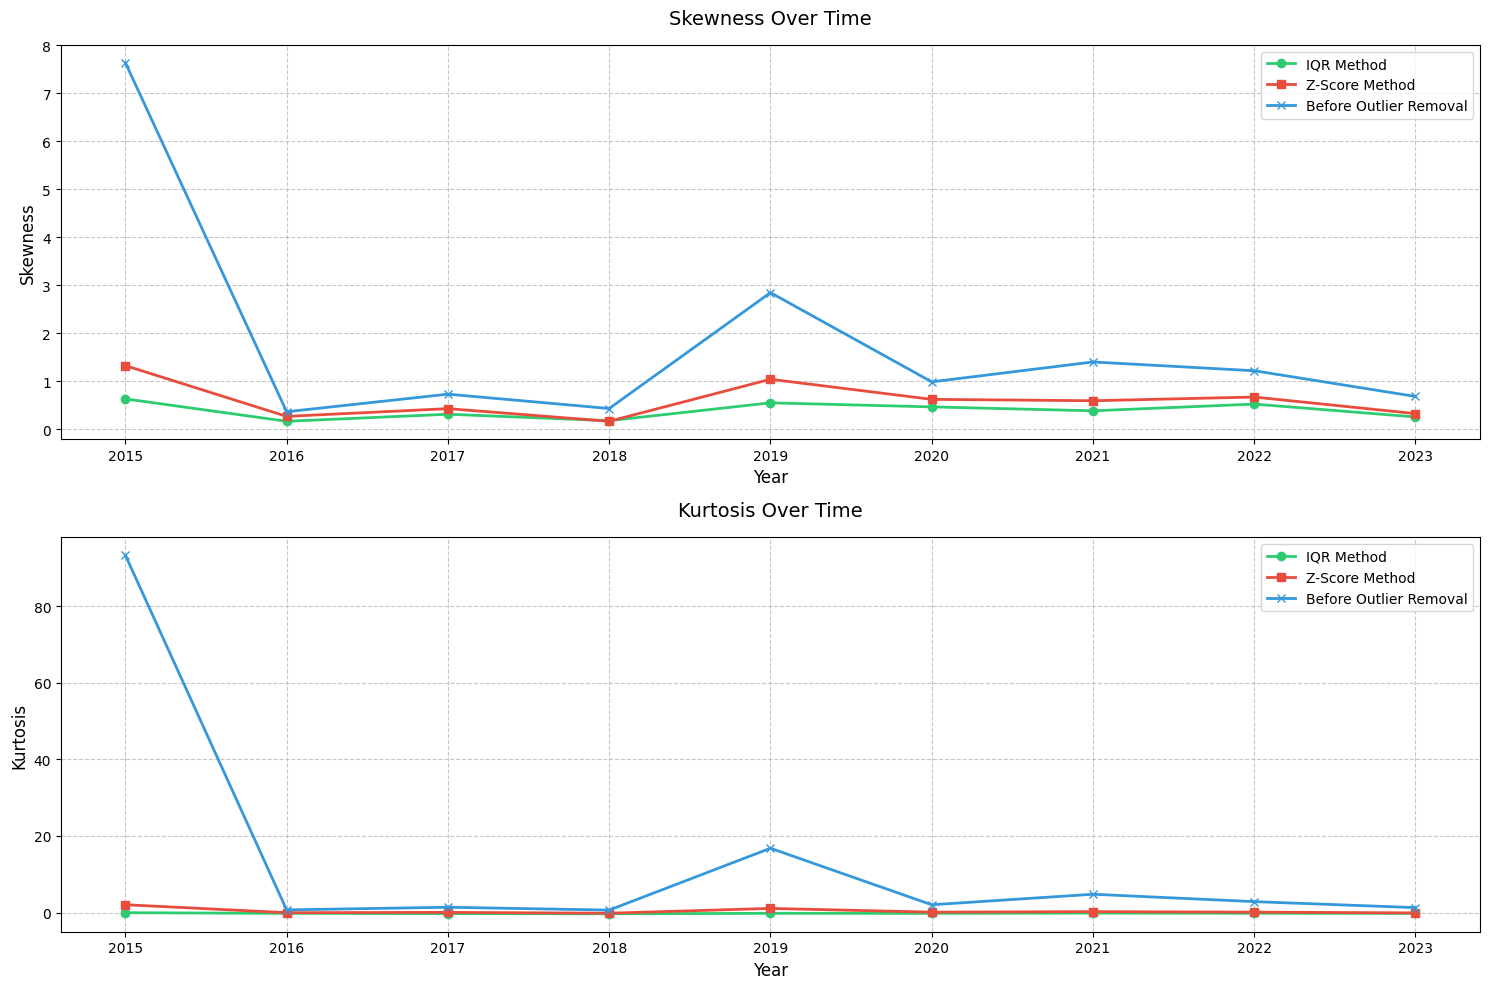

In [10]:
def Plot_Skewness_Kurtosis(df_stats_IQR, df_stats_Z_Score, df_stats):
    """
    This function plots the skewness and kurtosis of the WACC values for each year.
    
    Parameters:
    df_stats_IQR (DataFrame): The DataFrame containing the skewness and kurtosis values for each year using the IQR method.
    df_stats_Z_Score (DataFrame): The DataFrame containing the skewness and kurtosis values for each year using the Z-Score method.
    df_stats (DataFrame): The DataFrame containing the original skewness and kurtosis values before outlier removal.

    Returns:
    fig1 (Figure): The Figure object containing both skewness and kurtosis plots.
    """

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    plt.style.use('default')
    colors = {
        'IQR': '#2ecc71',
        'Z-Score': '#e74c3c',
        'Original': '#3498db'
    }
    
    # Plot of Skewness
    ax1.plot(df_stats_IQR['Year'], df_stats_IQR['Skewness'], marker='o', color=colors['IQR'], label='IQR Method', linewidth=2)
    ax1.plot(df_stats_Z_Score['Year'], df_stats_Z_Score['Skewness'], marker='s', color=colors['Z-Score'], label='Z-Score Method', linewidth=2)
    ax1.plot(df_stats['Year'], df_stats['Skewness'], marker='x', color=colors['Original'], label='Before Outlier Removal', linewidth=2)

    ax1.set_title('Skewness Over Time', fontsize=14, pad=15)
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel('Skewness', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend()

    # Plot of Kurtosis
    ax2.plot(df_stats_IQR['Year'], df_stats_IQR['Kurtosis'], marker='o', color=colors['IQR'], label='IQR Method', linewidth=2)
    ax2.plot(df_stats_Z_Score['Year'], df_stats_Z_Score['Kurtosis'], marker='s', color=colors['Z-Score'], label='Z-Score Method', linewidth=2)
    ax2.plot(df_stats['Year'], df_stats['Kurtosis'], marker='x', color=colors['Original'], label='Before Outlier Removal', linewidth=2)

    ax2.set_title('Kurtosis Over Time', fontsize=14, pad=15)
    ax2.set_xlabel('Year', fontsize=12)
    ax2.set_ylabel('Kurtosis', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend()

    plt.tight_layout()

    return fig

df_stats_IQR = Skewness_Kurtosis(EDA_df_IQR)
df_stats_Z_Score = Skewness_Kurtosis(EDA_df_Z_Score)
df_stats = Skewness_Kurtosis(EDA_df)
fig = Plot_Skewness_Kurtosis(df_stats_IQR, df_stats_Z_Score, df_stats)
plt.show()

# ARIMA Model:

The ARIMA model is a time series forecasting model that is used to predict future values based on the past values of the time series data. The ARIMA model is composed of three main components:

- Autoregression (AR): The AR component is a linear regression model that uses the past values of the time series data to predict the future values using a lag parameter p.

- Integrated (I): The I component is the differencing of the time series data to make it stationary, meaning that the mean and variance of the time series data are constant over time.


- Moving Average (MA): The MA component is a linear regression model that uses the past errors of the time series data to predict the future values.

The ARIMA model is defined by three parameters:

- p: The number of lag observations included in the model (AR).

- d: The number of times that the raw observations are differenced (I).

- q: The size of the moving average window (MA).



1st- Determining the ARIMA Model Parameters:

d- The differencing parameter d is determined by the augmented Dickey-Fuller test, where the augmented Dickey-Fuller test is used to determine if the time series data is stationary or not.

p- The lag parameter p is determined by the PACF plot, where the PACF plot is used to determine the correlation between the time series data and its lagged values. It is determined as follows:

- If the PACF plot has a sharp cutoff after lag p, then the value of p is the lag value where the cutoff occurs.

q- The moving average parameter q is determined by the ACF plot, where the ACF plot is used to determine the correlation between the time series data and its lagged errors. It is determined as follows:

- If the ACF plot has a sharp cutoff after lag q, then the value of q is the lag value where the cutoff occurs.

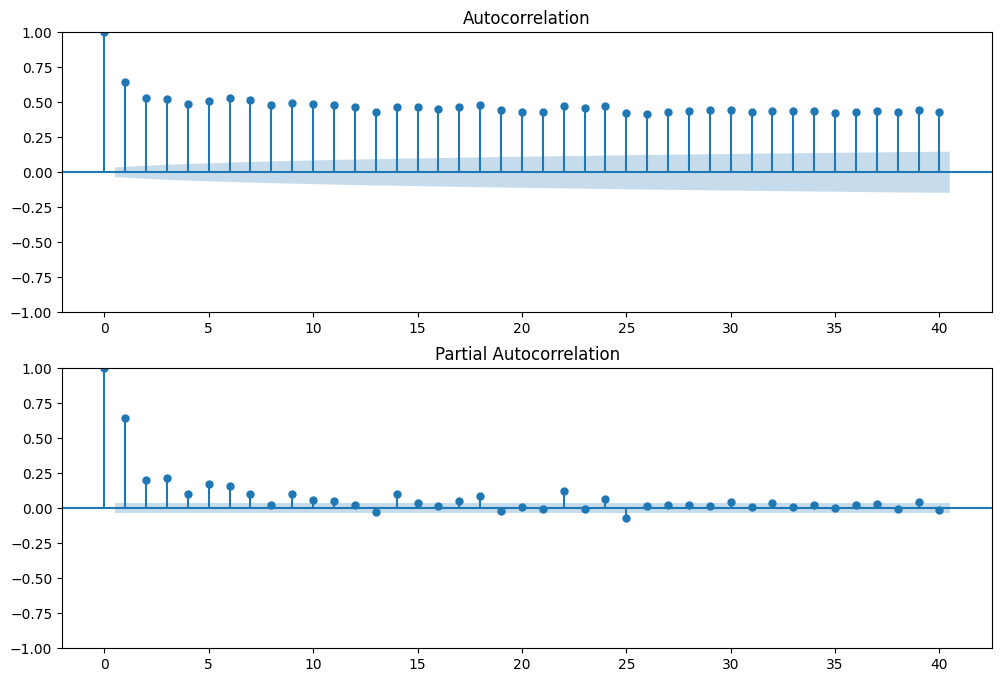

Optimal ARIMA parameters based on the Augmented Dickey-Fuller test and ACF/PACF plots: (1, 0, 1)


In [11]:
def determine_arima_parameters(df, column):
    """
    Determines optimal ARIMA (p, d, q) parameters based on time series analysis.
    It checks for stationarity using Augmented Dickey-Fuller test to determine the value of d (differencing, limited to a maximum of 5).
    It then uses the PACF and ACF plots to determine the values of p (autoregression) and q (moving average) parameters.

    Parameters:
    df (pd.DataFrame): DataFrame containing the time series data.
    column (str): Column name containing the time series values.

    Returns:
    tuple: Optimal (p, d, q) parameters for the ARIMA model.
    """
    df = df.sort_values(by='Date')
    series = df[column].dropna()


    adf_result = adfuller(series)
    d = 0
    if adf_result[1] > 0.05:
        while adf_result[1] > 0.05 and d < 5: 
            d += 1
            differenced_series = series.diff(d).dropna()
            adf_result = adfuller(differenced_series)

    if d > 0:
        differenced_series = series.diff(d).dropna()
    else:
        differenced_series = series

    nlags = 40
    acf_values,acf_confint = acf(differenced_series, nlags=nlags, alpha=0.05)
    pacf_values,pacf_confint = pacf(differenced_series, nlags=nlags, alpha=0.05)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    plot_acf(differenced_series, lags=nlags, ax=ax1)
    plot_pacf(differenced_series, lags=nlags, ax=ax2)

    p = next((i for i in range(1, len(pacf_values)) if pacf_confint[i][0] > 0 or pacf_confint[i][1] < 0), 0)
    q = next((i for i in range(1, len(acf_values)) if acf_confint[i][0] > 0 or acf_confint[i][1] < 0), 0)

    return p, d, q, fig

p, d, q , fig= determine_arima_parameters(EDA_df_IQR, 'WACC')

plt.show()

print(f"Optimal ARIMA parameters based on the Augmented Dickey-Fuller test and ACF/PACF plots: ({p}, {d}, {q})")

# Sensitivity Analysis:

We will analyse the impact of changing the parameters of the ARIMA model on the prediction accuracy, where we will change the values of the parameters p, and q and observe the impact on:

MSE: Mean Squared Error, which is a measure of the average squared difference between the actual and predicted values, measured by the formula:

- MSE = (1/n) * Σ(actual - predicted)^2

RMSE: Root Mean Squared Error, which is the square root of the MSE, measured by the formula:

- RMSE = sqrt(MSE)

MAE: Mean Absolute Error, which is a measure of the average absolute difference between the actual and predicted values, measured by the formula:

- MAE = (1/n) * Σ|actual - predicted|

MAPE: Mean Absolute Percentage Error, which is a measure of the average absolute percentage difference between the actual and predicted values, measured by the formula:

- MAPE = (1/n) * Σ(|actual - predicted| / actual) * 100

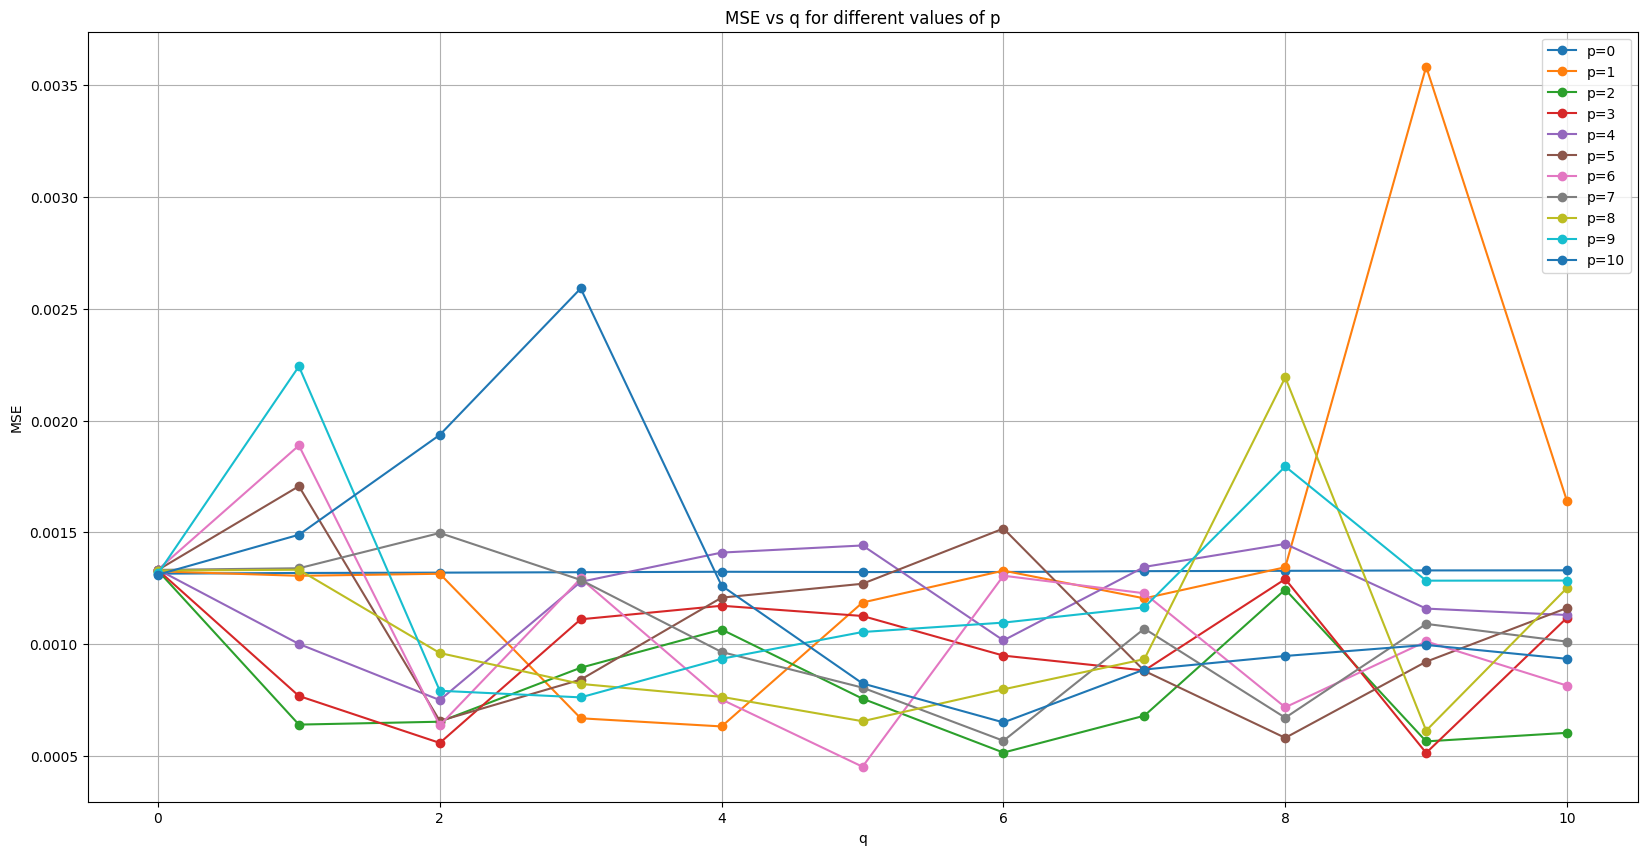

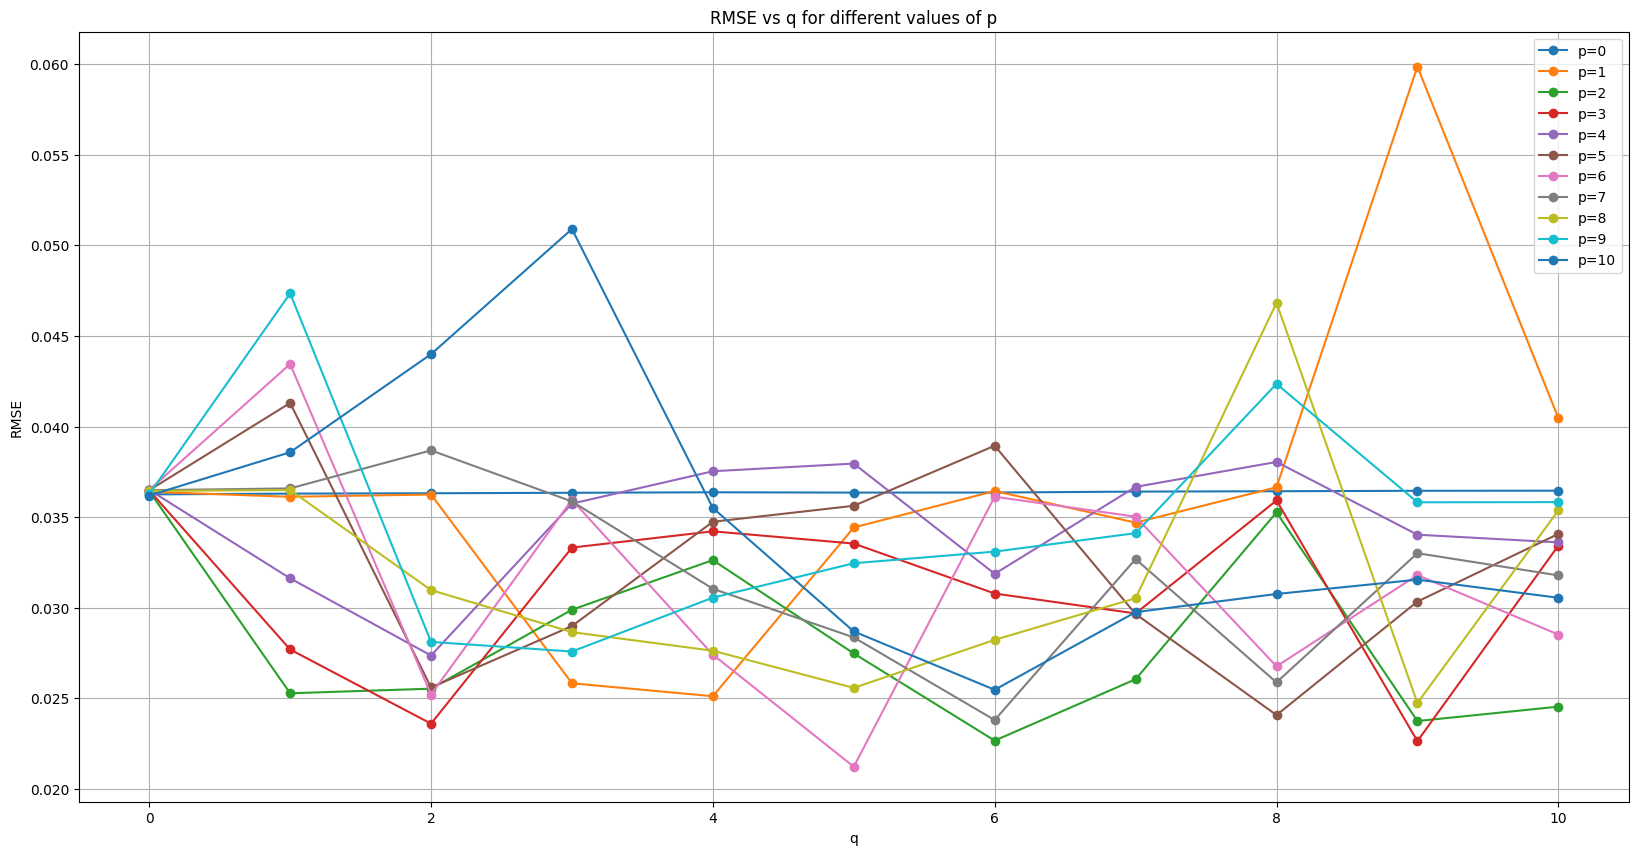

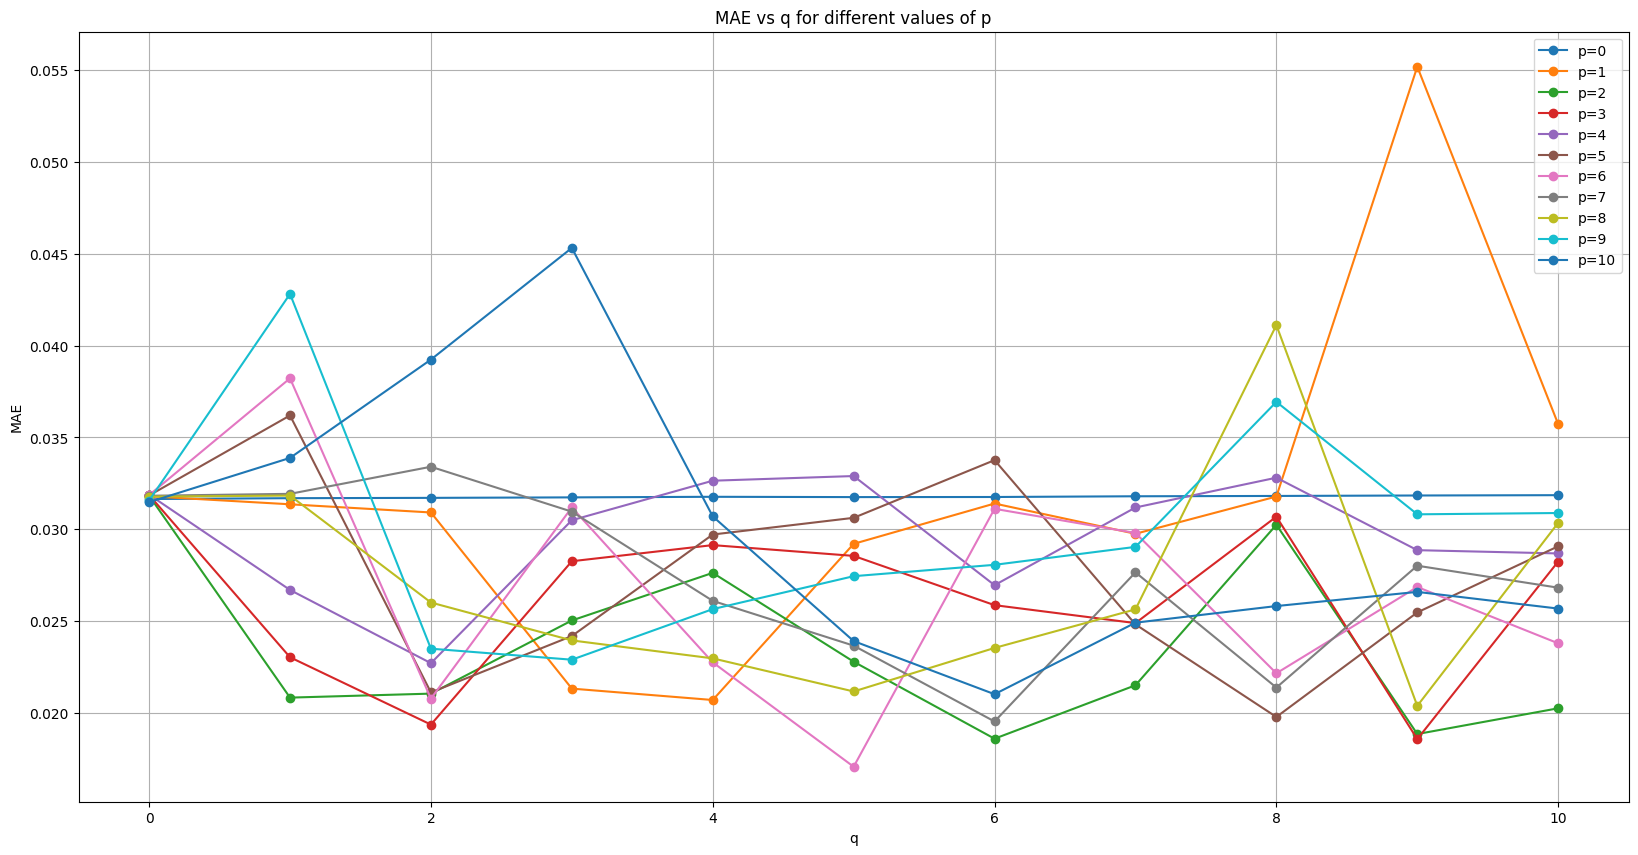

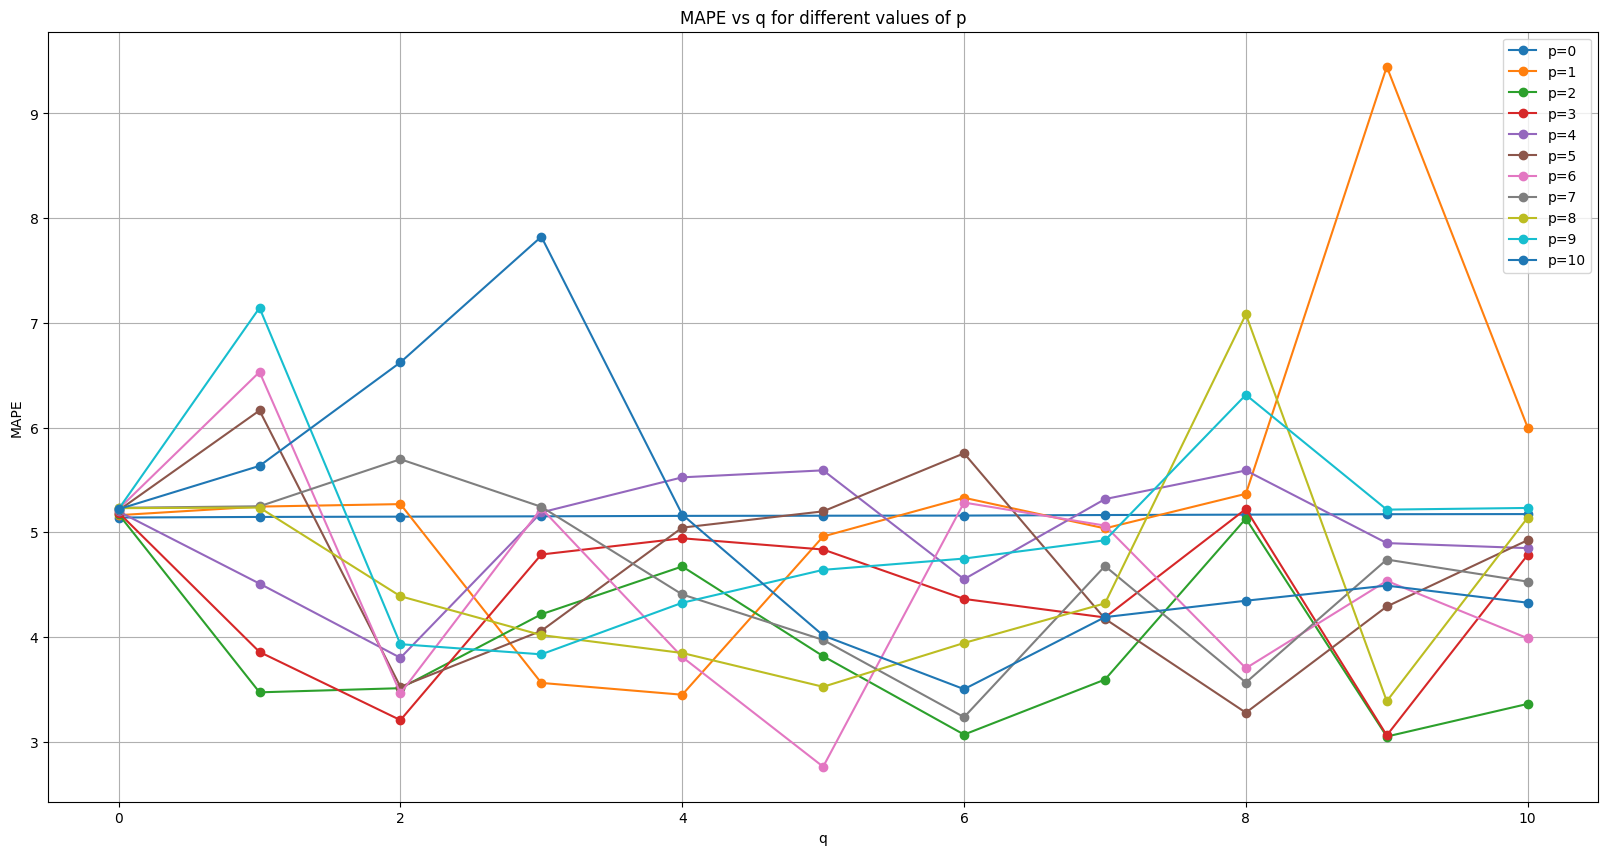

,p,q,MSE,RMSE,MAE,MAPE
0,0,0,0.001315,0.036257,0.031649,5.140779
1,0,1,0.001318,0.036300,0.031694,5.146481
2,0,2,0.001319,0.036321,0.031712,5.149100
3,0,3,0.001321,0.036347,0.031738,5.152413
4,0,4,0.001323,0.036375,0.031770,5.156598
...,...,...,...,...,...,...
116,10,6,0.000649,0.025475,0.021016,3.501599
117,10,7,0.000886,0.029759,0.024913,4.189520
118,10,8,0.000946,0.030762,0.025818,4.346281
119,10,9,0.000996,0.031553,0.026590,4.490624


In [12]:
def sensitivity_analysis_arima(df, column, max_p, max_q, d, test_size=0.2):
    """
    Conducts sensitivity analysis on ARIMA (p, d, q) parameters to evaluate model performance metrics.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    column (str): Name of the column to be used for training and forecasting.
    max_p (int): Maximum value of p to iterate over.
    max_q (int): Maximum value of q to iterate over.
    d (int): Degree of differencing.
    test_size (float): Proportion of data to be used for testing.

    Returns:
    pd.DataFrame: DataFrame containing evaluation metrics for each (p, q) combination.
    """
    dates = df['Date']
    series = df[column].copy()

    train_size = int(len(series) * (1 - test_size))
    train, test = series[:train_size], series[train_size:]
    
    results = []

    for p,q in itertools.product(range(max_p+1), range(max_q+1)):
        model = ARIMA(train, order=(p, d, q))
        model_fit = model.fit()
        test_predict = model_fit.predict(start=len(train), end=len(train)+len(test)-1)
        residuals = test - test_predict

        mse = mean_squared_error(test, test_predict)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(test, test_predict)
        mape = np.mean(np.abs(residuals / test)) * 100

        results.append({
            'p': p,
            'q': q,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape
            
        })

    df_results = pd.DataFrame(results)
    metrics = ['MSE', 'RMSE', 'MAE', 'MAPE']

    for metric in metrics:
        plt.figure(figsize=(20, 10))
        for p in range(max_p + 1):
            subset = df_results[df_results['p'] == p]
            plt.plot(subset['q'], subset[metric], marker='o', label=f'p={p}')
        plt.title(f'{metric} vs q for different values of p')
        plt.xlabel('q')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)
        plt.show()

    return df_results

df_results = sensitivity_analysis_arima(EDA_df_IQR, 'WACC', max_p=10, max_q=10, d=0, test_size=0.2)
df_results

In [13]:
metrics = ['MSE', 'RMSE', 'MAE', 'MAPE']

best_configurations = {}
for metric in metrics:
    best_configurations[metric] = df_results.iloc[df_results[metric].idxmin()]

for metric, config in best_configurations.items():
    print(f"Best config for {metric} is:\n{config}\n")

Best config for MSE is:
p       6.000000
q       5.000000
MSE     0.000451
RMSE    0.021229
MAE     0.017066
MAPE    2.760730
Name: 71, dtype: float64

Best config for RMSE is:
p       6.000000
q       5.000000
MSE     0.000451
RMSE    0.021229
MAE     0.017066
MAPE    2.760730
Name: 71, dtype: float64

Best config for MAE is:
p       6.000000
q       5.000000
MSE     0.000451
RMSE    0.021229
MAE     0.017066
MAPE    2.760730
Name: 71, dtype: float64

Best config for MAPE is:
p       6.000000
q       5.000000
MSE     0.000451
RMSE    0.021229
MAE     0.017066
MAPE    2.760730
Name: 71, dtype: float64



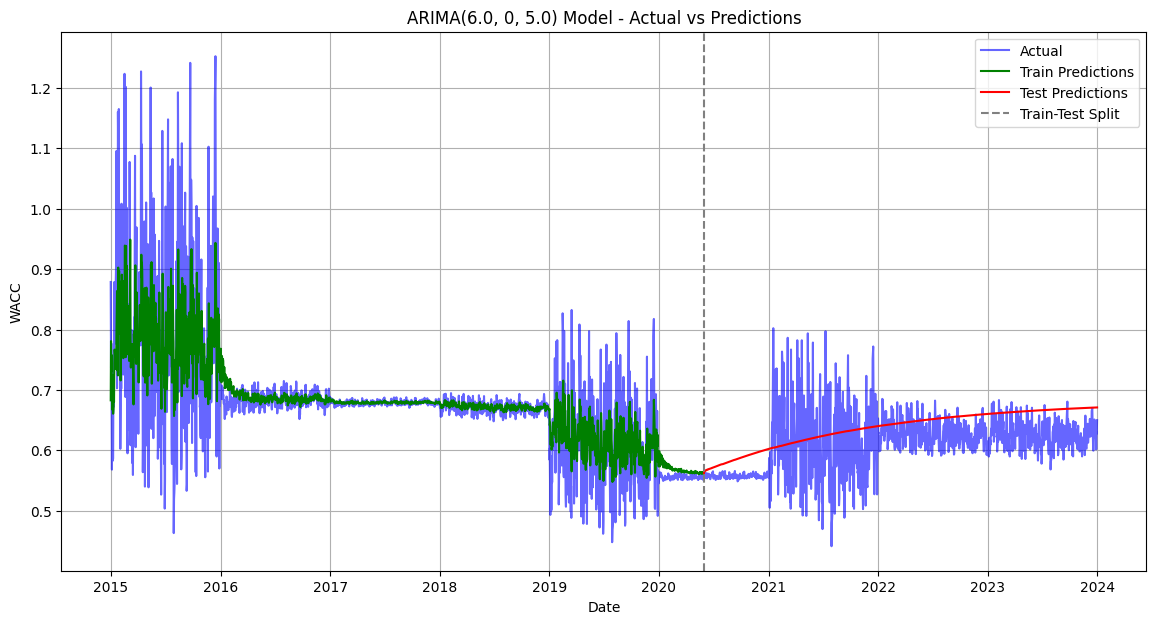

mse: 0.002429049962476816
rmse: 0.049285392993023966
mae: 0.03989666950165128
mape: 6.639784085182381


In [14]:
def train_evaluate_ARIMA(df, column, p, d, q, test_size=0.2):
    """
    Trains an ARIMA model on the specified column of the input DataFrame, evaluates its performance,
    and forecasts future values.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data.
    column (str): Name of the column to be used for training and forecasting.
    p, d, q (int): ARIMA model hyperparameters.
    test_size (float): Proportion of data to be used for testing.
    

    Returns:
    dict: A dictionary containing the trained model, predictions, residuals and evaluation metrics
    """
    df = df.sort_values(by='Date').reset_index(drop=True)
    dates = df['Date']
    series = df[column].copy()
    series_to_use =series
    train_size = int(len(series_to_use) * (1 - test_size))
    train, test = series_to_use[:train_size], series_to_use[train_size:]
    train_dates, test_dates = dates[:train_size], dates[train_size:]

    d = 0
    model = ARIMA(train, order=(p, d, q))
    arima_fit = model.fit()
    train_predictions = arima_fit.predict(start=0, end=len(train)-1)
    test_predictions = arima_fit.predict(start=len(train), end=len(train) + len(test) - 1)
    residuals = test - test_predictions

    mse = mean_squared_error(test, test_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test, test_predictions)
    mape = np.mean(np.abs(residuals / test)) * 100

    # Plot actual vs predicted values on train and test sets
    plt.figure(figsize=(14, 7))
    plt.plot(dates, series_to_use, label='Actual', color='blue', alpha=0.6)
    plt.plot(train_dates, train_predictions, label='Train Predictions', color='green')
    plt.plot(test_dates, test_predictions, label='Test Predictions', color='red')
    plt.axvline(dates.iloc[train_size], color='gray', linestyle='--', label='Train-Test Split')
    plt.title(f"ARIMA({p}, {d}, {q}) Model - Actual vs Predictions")
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        'model': arima_fit,
        'train_predictions': train_predictions,
        'test_predictions': test_predictions,
        'residuals': residuals,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
    }

best_config = best_configurations['MSE']
best_p = best_config['p']
best_q = best_config['q']

results = train_evaluate_ARIMA(EDA_df_IQR, 'WACC', best_p, 0, best_q, test_size=0.4)
for key, value in results.items():
    if key not in ['model', 'train_predictions', 'test_predictions','residuals']:
        print(f"{key}: {value}")

ARIMA_Resuls = {
    'MSE': results['mse'],
    'RMSE': results['rmse'],
    'MAE': results['mae'],
    'MAPE': results['mape']
}


Iterative Forecasting: We will use the ARIMA model to iteratively forecast the future values of the time series data, where we will use the actual values to predict the future values, and then use the predicted values to predict the next future values, and so on.



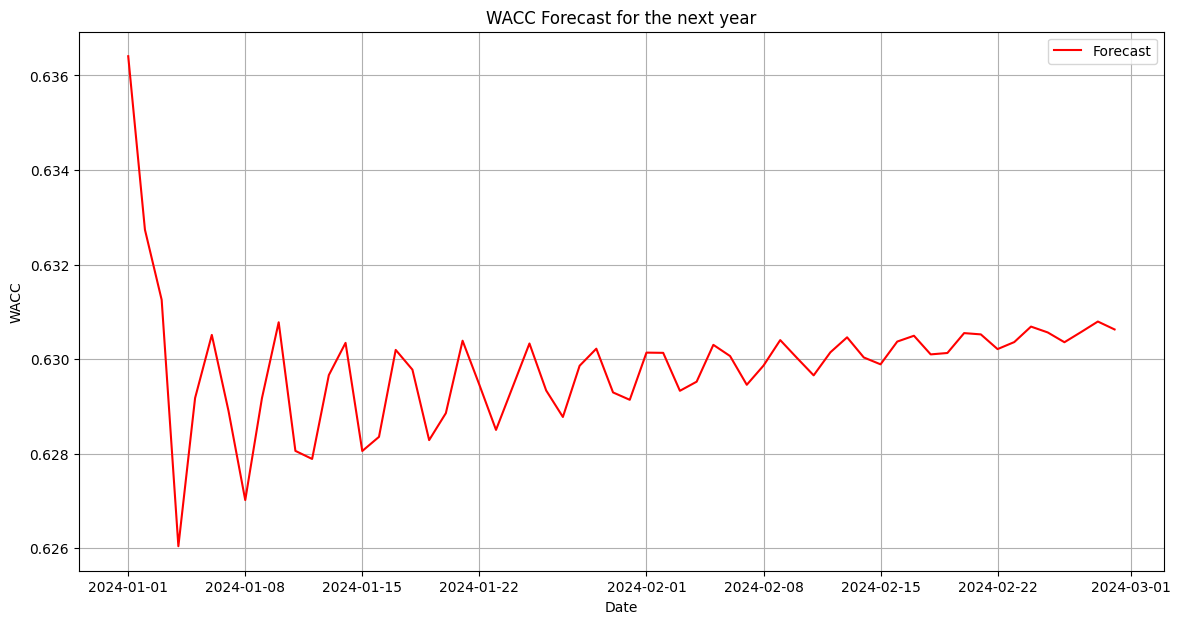

In [15]:

model = ARIMA(EDA_df_IQR['WACC'], order=(best_p, 0, best_q))
model_fit = model.fit()
forecast = model_fit.forecast(steps=1).iloc[0]
forecast_series = model_fit.forecast(steps=60)
forecast_dates = pd.date_range(start=EDA_df_IQR['Date'].max() + timedelta(days=1), periods=60, freq='D')

plt.figure(figsize=(14, 7))
plt.plot(forecast_dates, forecast_series, label='Forecast', color='red')
plt.title("WACC Forecast for the next year")
plt.xlabel('Date')
plt.ylabel('WACC')
plt.legend()
plt.grid(True)
plt.show()

# LSTM Forecast Model:

In [16]:
LSTM_df_IQR = EDA_df_IQR.copy()
LSTM_df_IQR = LSTM_df_IQR.drop(columns=['Year', 'Company Name'])
LSTM_df_IQR = LSTM_df_IQR.set_index('Date').sort_index()

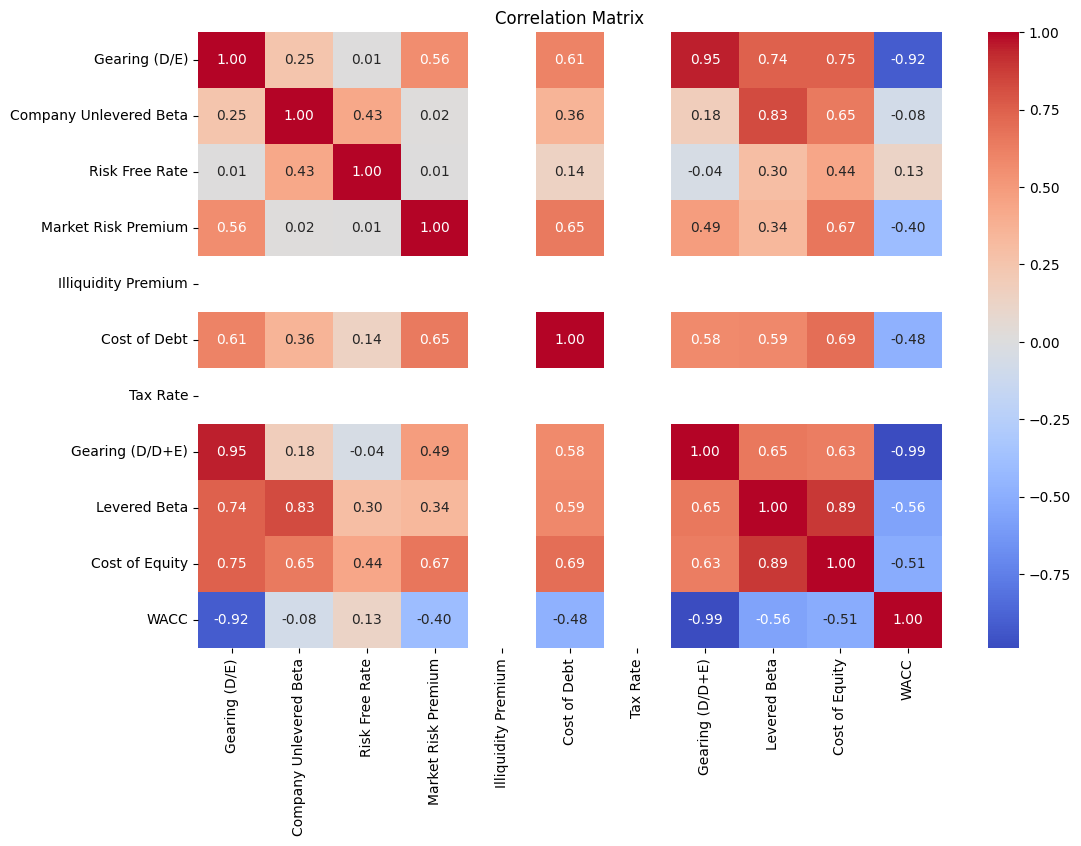

Gearing (D/D+E)           0.988578
Gearing (D/E)             0.916807
Levered Beta              0.562478
Cost of Equity            0.510317
Cost of Debt              0.478321
Market Risk Premium       0.402802
Risk Free Rate            0.128411
Company Unlevered Beta    0.077981
Illiquidity Premium            NaN
Tax Rate                       NaN
Name: WACC, dtype: float64

In [17]:
def Correlation_Analysis(df):
    """
    This function calculates the correlation between the WACC values and the other features in the dataset.

    Parameters:
    ----------
    df : the pandas DataFrame containing the data.

    Returns:
    -------
    pd.DataFrame
        A DataFrame containing the correlation values between WACC and other features.
    """
    corr_matrix = df.corr()
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix')
    plt.show()

    corr_WACC = corr_matrix['WACC'].drop('WACC').abs().sort_values(ascending=False)
    return corr_WACC

corr_WACC = Correlation_Analysis(LSTM_df_IQR)
corr_WACC

In [18]:
LSTM_features = corr_WACC.head(6).index.tolist()
LSTM_features.append('WACC')
LSTM_df_IQR = LSTM_df_IQR[LSTM_features]
scaler = MinMaxScaler()
LSTM_df_IQR_scaled = scaler.fit_transform(LSTM_df_IQR)
LSTM_df_IQR_scaled = pd.DataFrame(LSTM_df_IQR_scaled, columns=LSTM_df_IQR.columns, index=LSTM_df_IQR.index)



In [19]:
def create_sequences(df, features, target, time_steps=60):
    """
    Creates sequences of data for LSTM.

    Parameters:
    df (pd.DataFrame): Scaled DataFrame containing features and target.
    features (list): List of feature column names.
    target (str): Target column name.
    time_steps (int): Number of past time steps to include in each input sequence.

    Returns:
    np.array: Input sequences.
    np.array: Corresponding target values.
    """
    X, y = [], []
    for i in range(time_steps, len(df)):
        X.append(df[features].iloc[i-time_steps:i].values)
        y.append(df[target].iloc[i])
    return np.array(X), np.array(y)

features = LSTM_features[:-1]
target = 'WACC'
time_steps = 60
X,y = create_sequences(LSTM_df_IQR_scaled, features, target, time_steps)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3137, 60, 6)
y shape: (3137,)


In [20]:
train_size = int(0.6 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [21]:
def build_lstm_model(input_shape):
    """
    Builds an LSTM model.

    Parameters:
    input_shape (tuple): Shape of the input data.

    Returns:
    tf.keras.models.Sequential: LSTM model.
    """
    model = Sequential([
        LSTM(128, activation='sigmoid', return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        LSTM(64, activation='sigmoid', return_sequences=True),
        BatchNormalization(),
        LSTM(32, activation='sigmoid', return_sequences=False),
        Dropout(0.075),
        Dense(1, activation='tanh')
    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mape'])
    return model

model = build_lstm_model(X_train.shape[1:])
model.summary()


EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping], verbose=1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 60, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,745 (514.63 KB)

 Trainable params: 131,361 (513.13 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0258 - mae: 0.1218 - mape: 43.8002 - val_loss: 0.0485 - val_mae: 0.2087 - val_mape: 178.1989
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0159 - mae: 0.0888 - mape: 32.3873 - val_loss: 0.0537 - val_mae: 0.2205 - val_mape: 187.1180
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0105 - mae: 0.0700 - mape: 25.6900 - val_loss: 0.0522 - val_mae: 0.2173 - val_mape: 184.6251
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0076 - mae: 0.0567 - mape: 20.9888 - val_loss: 0.0584 - val_mae: 0.2307 - val_mape: 194.6955
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0087 - mae: 0.0615 - mape: 25.2680 - val_loss: 0.0466 - val_mae: 0.2045 - val_mape: 174.6374
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0084 - mae: 0.0528 - mape: 20.1543 - val_loss: 0.0584 - val_mae: 0.2310 - val_mape: 194.2670
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0087 - m

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Test MSE: 0.0020
Test MAE: 0.0318
Test MAPE: 5.16%
Test RMSE: 0.0451


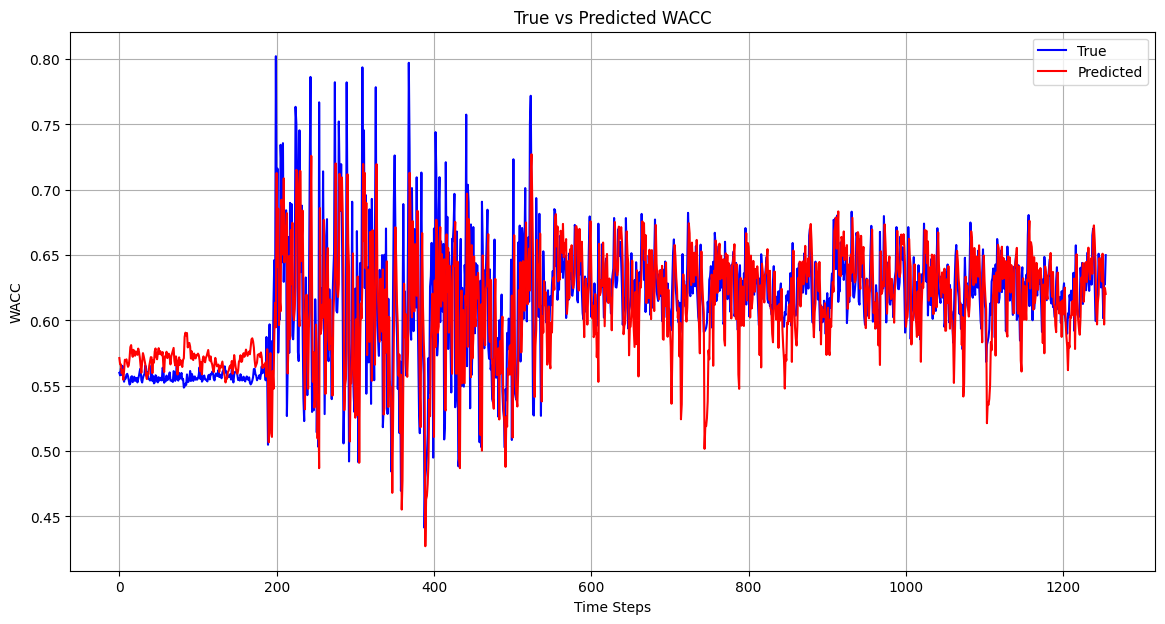

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt


y_pred = model.predict(X_test)

y_pred = y_pred.reshape(-1, 1) 
y_test = y_test.reshape(-1, 1)
y_pred_inverse = scaler.inverse_transform(np.hstack([np.zeros((y_pred.shape[0], len(features))), y_pred]))[:, -1]
y_test_inverse = scaler.inverse_transform(np.hstack([np.zeros((y_test.shape[0], len(features))), y_test]))[:, -1]
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
mape = np.mean(np.abs((y_test_inverse - y_pred_inverse) / y_test_inverse)) * 100
rmse = np.sqrt(mse)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test RMSE: {rmse:.4f}")


LSTM_Results = {
    'MSE': mse,
    'MAE': mae,
    'MAPE': mape,
    'RMSE': rmse
}


def plot_predictions(y_true, y_pred):
    """
    Plots the true and predicted values.

    Parameters:
    y_true (np.array): True target values.
    y_pred (np.array): Predicted target values.
    """
    plt.figure(figsize=(14, 7))
    plt.plot(y_true, label='True', color='blue')
    plt.plot(y_pred, label='Predicted', color='red')
    plt.title('True vs Predicted WACC')
    plt.xlabel('Time Steps')
    plt.ylabel('WACC')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_predictions(y_test_inverse, y_pred_inverse)


# LSTM - ARIMA Model:

In [23]:
LSTM_df_IQR

,Gearing (D/D+E),Gearing (D/E),Levered Beta,Cost of Equity,Cost of Debt,Market Risk Premium,WACC
Date,,,,,,,
2014-12-31,0.206349,0.260000,0.874167,1.096192,0.061000,0.070000,0.878679
2015-01-01,0.349535,0.537361,1.022496,1.107341,0.067104,0.070750,0.736471
2015-01-02,0.305681,0.440260,0.959550,1.102636,0.054259,0.070487,0.777026
2015-01-03,0.405780,0.682879,1.097875,1.113106,0.067527,0.071143,0.680336
2015-01-04,0.529966,1.127508,1.366048,1.133826,0.096015,0.072345,0.568047
...,...,...,...,...,...,...,...
2023-12-27,0.460869,0.854836,1.026274,1.127691,0.051236,0.086263,0.624267
2023-12-28,0.505693,1.023033,1.220097,1.171407,0.064642,0.092732,0.601590
2023-12-29,0.453710,0.830529,1.009579,1.124285,0.050519,0.085328,0.630001


Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.1633 - mae: 0.3097 - mape: 108.7151 - val_loss: 0.0080 - val_mae: 0.0596 - val_mape: 36.1633
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0199 - mae: 0.1093 - mape: 41.6797 - val_loss: 0.0059 - val_mae: 0.0492 - val_mape: 36.1039
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0203 - mae: 0.1116 - mape: 41.9353 - val_loss: 0.0058 - val_mae: 0.0502 - val_mape: 37.2960
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0198 - mae: 0.1049 - mape: 38.9247 - val_loss: 0.0062 - val_mae: 0.0466 - val_mape: 32.2801
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0146 - mae: 0.0894 - mape: 34.4964 - val_loss: 0.0062 - val_mae: 0.0466 - val_mape: 32.4503
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0148 - mae: 0.0915 - mape: 33.4515 - val_loss: 0.0066 - val_mae: 0.0480 - val_mape: 31.6062
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0147 - mae: 0

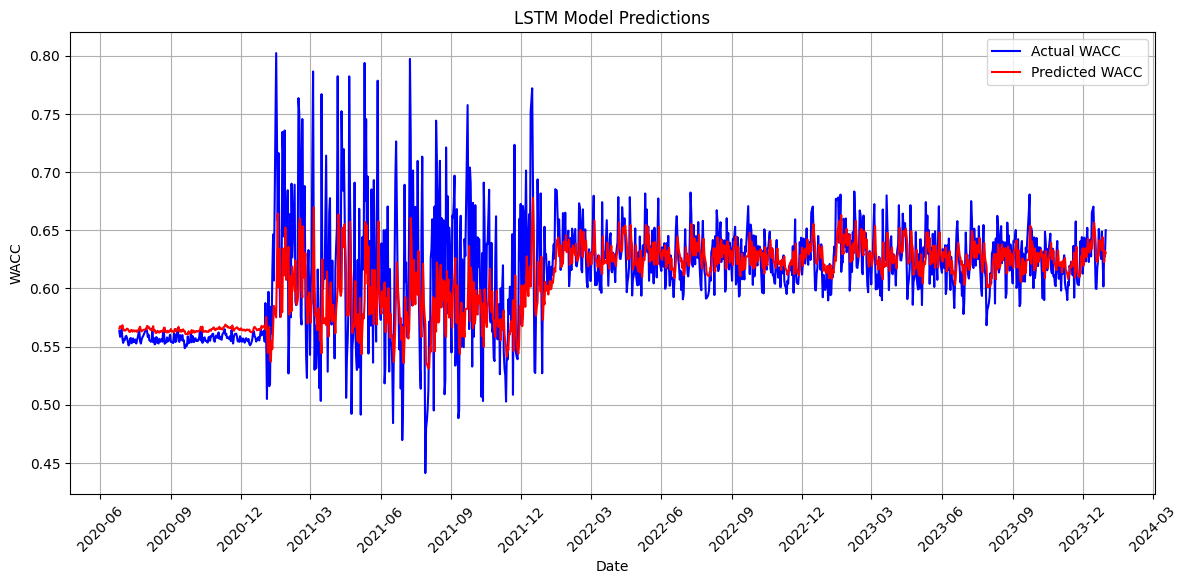

In [72]:

import matplotlib.dates as mdates


data = LSTM_df_IQR[['WACC']].copy()
data['Volatility'] = data['WACC'].pct_change().rolling(window=5).std()

def train_arima(data):
    model = ARIMA(data['WACC'].dropna(), order=(6, 0, 5))
    model_fit = model.fit()
    residuals = pd.Series(model_fit.resid, index=data['WACC'].dropna().index)
    return model_fit, residuals

def prepare_lstm_data(data, sequence_length, residuals=None):
    features = ['WACC', 'Volatility']
    if residuals is not None:
        data = data.copy()
        data['Residuals'] = residuals
        features.append('Residuals')
    
    data = data[features].dropna()
    X_data = data[features]
    y_data = data['WACC']

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    scaled_X = scaler_X.fit_transform(X_data)
    scaled_y = scaler_y.fit_transform(y_data.values.reshape(-1, 1))

    X, y = [], []
    for i in range(sequence_length, len(scaled_X)):
        X.append(scaled_X[i - sequence_length:i])
        y.append(scaled_y[i])
    X = np.array(X)
    y = np.array(y)
    indices = data.index[sequence_length:]
    return X, y, scaler_X, scaler_y, indices

def build_lstm_model(input_shape):
    """
    Builds an LSTM model.

    Parameters:
    input_shape (tuple): Shape of the input data.

    Returns:
    tf.keras.models.Sequential: LSTM model.
    """
    model = Sequential([
        LSTM(128, activation='sigmoid', return_sequences=True, input_shape=input_shape),
        BatchNormalization(),
        LSTM(64, activation='sigmoid', return_sequences=True),
        BatchNormalization(),
        LSTM(32, activation='sigmoid', return_sequences=False),
        Dropout(0.075),
        Dense(1, activation='tanh')
    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mape'])
    return model

def train_lstm(X_train, y_train):
    model = build_lstm_model(X_train.shape[1:])
    
    history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=1)
    return model, history

def plot_LSTM_predictions(dates, y_true, y_pred):
    plt.figure(figsize=(14, 6))
    plt.plot(dates, y_true, label='Actual WACC', color='blue')
    plt.plot(dates, y_pred, label='Predicted WACC', color='red')
    plt.title('LSTM Model Predictions')
    plt.xlabel('Date')
    plt.ylabel('WACC')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.show()


model_arima, residuals = train_arima(data)
sequence_length = 60
X, y, scaler_X, scaler_y, indices = prepare_lstm_data(data, sequence_length, residuals)
train_size = int(0.6 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
indices_train, indices_test = indices[:train_size], indices[train_size:]
model_lstm, history = train_lstm(X_train, y_train)

y_pred = model_lstm.predict(X_test)
y_test = y_test.reshape(-1, 1)
y_pred = y_pred.reshape(-1, 1)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)


plot_LSTM_predictions(indices_test, y_test_inv.flatten(), y_pred_inv.flatten())


In [73]:
MSE = mean_squared_error(y_test_inv, y_pred_inv)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_test_inv, y_pred_inv)
MAPE = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100


print(f'Mean Squared Error (MSE): {MSE:.4f}')
print(f'Root Mean Squared Error (RMSE): {RMSE:.4f}')
print(f'Mean Absolute Error (MAE): {MAE:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%')

# gather the results in a dictionary called Hybrid_ARIMA_LSTM_Results
Hybrid_ARIMA_LSTM_Results = {
    'MSE': MSE,
    'RMSE': RMSE,
    'MAE': MAE,
    'MAPE': MAPE
}


Mean Squared Error (MSE): 0.0016
Root Mean Squared Error (RMSE): 0.0403
Mean Absolute Error (MAE): 0.0259
Mean Absolute Percentage Error (MAPE): 4.13%


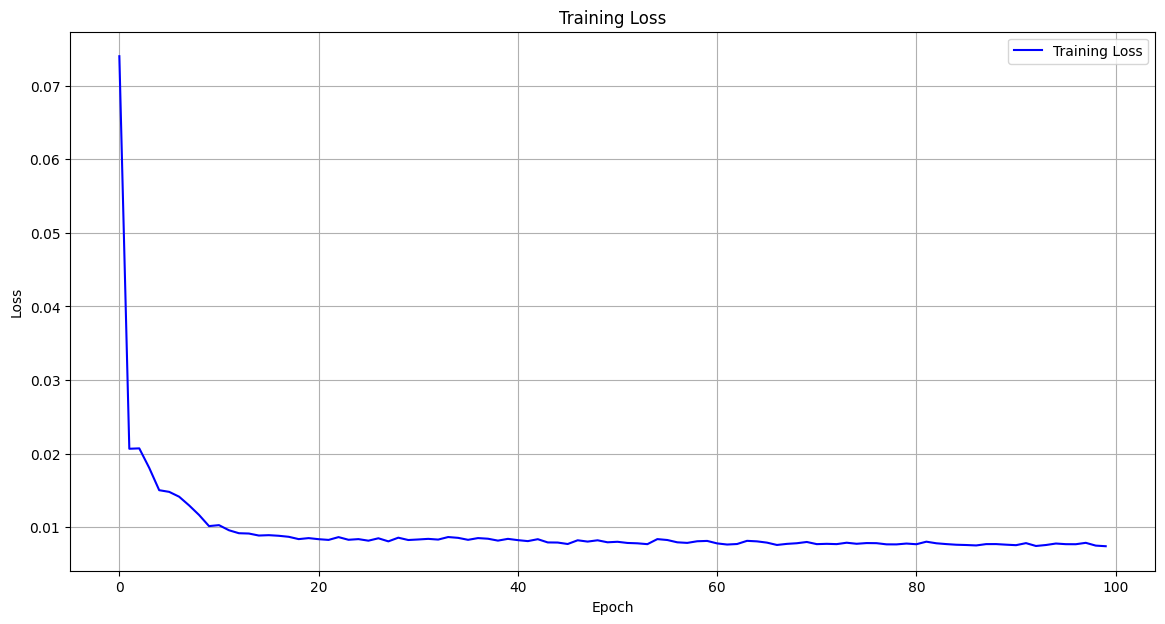

In [74]:
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [75]:
# print all the results in the 3 different dictionaries
print("ARIMA Results:")
print(ARIMA_Resuls)
print("\nLSTM Results:")
print(LSTM_Results)
print("\nHybrid ARIMA LSTM Results:")
print(Hybrid_ARIMA_LSTM_Results)

ARIMA Results:
{'MSE': 0.002429049962476816, 'RMSE': 0.049285392993023966, 'MAE': 0.03989666950165128, 'MAPE': 6.639784085182381}

LSTM Results:
{'MSE': 0.002033177257224723, 'MAE': 0.03184595278968006, 'MAPE': 5.16320361432844, 'RMSE': 0.04509076687332699}

Hybrid ARIMA LSTM Results:
{'MSE': 0.0016239972045988629, 'RMSE': 0.040298848675847584, 'MAE': 0.025888910483716953, 'MAPE': 4.12688216956731}
